In [323]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [324]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [325]:
print("="*70)
print("STEP 1: Load and prepare data")
print("="*70)

STEP 1: Load and prepare data


In [326]:
df = pd.read_csv("filtered_readings.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

# Handle missing values with forward fill
numeric_cols = ['gravity', 'brix', 'temperature']
df[numeric_cols] = df[numeric_cols].ffill()

In [327]:
print("="*70)
print("STEP 2: Remove outliers using IQR")
print("="*70)

STEP 2: Remove outliers using IQR


In [328]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

for col in numeric_cols:
    df = remove_outliers(df, col)

# Apply bounds
df = df[(df['gravity'] > 0.95) & (df['gravity'] < 1.3)]
df = df[(df['brix'] > -2) & (df['brix'] < 10)]
df = df[(df['temperature'] > 15) & (df['temperature'] < 40)]

In [329]:
print("="*70)
print("STEP 3: Featured Engineering")
print("="*70)

STEP 3: Featured Engineering


In [330]:
features = ['gravity', 'brix', 'temperature']

In [331]:
print("="*70)
print("STEP 4: Split data temporally (80/20)")
print("="*70)

STEP 4: Split data temporally (80/20)


In [332]:
split_index = int(0.8 * len(df))
train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

In [333]:
print("="*70)
print("STEP 5: Scale")
print("="*70)

STEP 5: Scale


In [334]:
scaler = MinMaxScaler()
scaler.fit(train_df[features])
train_scaled = pd.DataFrame(scaler.transform(train_df[features]), columns=features)
test_scaled = pd.DataFrame(scaler.transform(test_df[features]), columns=features)

# Function to inverse scale brix
def inverse_brix(pred):
    dummy = np.zeros((len(pred), len(features)))
    dummy[:, 1] = pred  # brix is at index 1
    return scaler.inverse_transform(dummy)[:, 1]

In [335]:
print("="*70)
print("STEP 6: Create Sequences")
print("="*70)

STEP 6: Create Sequences


In [336]:
SEQ_LEN = 30  # Increase from 15 to 30-50 as specified

def create_sequences(scaled_data, original_df, seq_len):
    X, y_brix, y_class = [], [], []
    for i in range(len(scaled_data) - seq_len):
        seq = scaled_data.iloc[i:i+seq_len].values
        target_brix = scaled_data.iloc[i+seq_len]['brix']  # Scaled for regression
        target_class = 1 if original_df.iloc[i+seq_len]['brix'] <= 0.4 else 0  # Based on original
        X.append(seq)
        y_brix.append(target_brix)
        y_class.append(target_class)
    return np.array(X), np.array(y_brix), np.array(y_class)

X_train, y_train_brix, y_train_class = create_sequences(train_scaled, train_df, SEQ_LEN)
X_test, y_test_brix, y_test_class = create_sequences(test_scaled, test_df, SEQ_LEN)

In [337]:
print("="*70)
print("STEP 6: Model builder (LSTM or BiLSTM)")
print("="*70)

STEP 6: Model builder (LSTM or BiLSTM)


In [338]:
def build_model(bidirectional=False):
    inputs = Input(shape=(SEQ_LEN, len(features)))
    if bidirectional:
        x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
        x = Dropout(0.2)(x)
        x = Bidirectional(LSTM(50))(x)
    else:
        x = LSTM(50, return_sequences=True)(inputs)
        x = Dropout(0.2)(x)
        x = LSTM(50)(x)
    x = Dropout(0.2)(x)
    reg_out = Dense(1, activation='linear', name='reg_out')(x)
    cls_out = Dense(1, activation='sigmoid', name='cls_out')(x)
    model = Model(inputs, [reg_out, cls_out])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss={'reg_out': 'mse', 'cls_out': 'binary_crossentropy'},
                  metrics={'reg_out': 'mae', 'cls_out': 'accuracy'})
    return model

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

In [339]:
# Train LSTM
lstm_model = build_model(bidirectional=False)
history_lstm = lstm_model.fit(
    X_train, {'reg_out': y_train_brix, 'cls_out': y_train_class},
    epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1
)
lstm_val_loss = min(history_lstm.history['val_loss'])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - cls_out_accuracy: 0.6931 - cls_out_loss: 0.5959 - loss: 0.6764 - reg_out_loss: 0.0799 - reg_out_mae: 0.2021 - val_cls_out_accuracy: 0.0000e+00 - val_cls_out_loss: 0.7269 - val_loss: 0.7312 - val_reg_out_loss: 6.0504e-05 - val_reg_out_mae: 0.0070 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - cls_out_accuracy: 0.6931 - cls_out_loss: 0.5959 - loss: 0.6764 - reg_out_loss: 0.0799 - reg_out_mae: 0.2021 - val_cls_out_accuracy: 0.0000e+00 - val_cls_out_loss: 0.7269 - val_loss: 0.7312 - val_reg_out_loss: 6.0504e-05 - val_reg_out_mae: 0.0070 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - cls_out_accuracy: 0.7591 - cls_out_loss: 0.3375 - loss: 0.3602 - reg_out_loss: 0.0219 - reg_out_mae: 0.1068 - val_cls_out_accuracy: 1.0000 - val_cls_out_loss: 0.4223 - val_loss: 0.4340 - val_reg_out_loss: 0.0092 - val_reg_out_mae: 0.0966 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━

In [340]:
# Train BiLSTM
bilstm_model = build_model(bidirectional=True)
history_bilstm = bilstm_model.fit(
    X_train, {'reg_out': y_train_brix, 'cls_out': y_train_class},
    epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1
)
bilstm_val_loss = min(history_bilstm.history['val_loss'])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - cls_out_accuracy: 0.6392 - cls_out_loss: 0.6012 - loss: 0.6941 - reg_out_loss: 0.0914 - reg_out_mae: 0.2169 - val_cls_out_accuracy: 0.0000e+00 - val_cls_out_loss: 0.7210 - val_loss: 0.7269 - val_reg_out_loss: 7.0833e-05 - val_reg_out_mae: 0.0068 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - cls_out_accuracy: 0.6392 - cls_out_loss: 0.6012 - loss: 0.6941 - reg_out_loss: 0.0914 - reg_out_mae: 0.2169 - val_cls_out_accuracy: 0.0000e+00 - val_cls_out_loss: 0.7210 - val_loss: 0.7269 - val_reg_out_loss: 7.0833e-05 - val_reg_out_mae: 0.0068 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - cls_out_accuracy: 0.7997 - cls_out_loss: 0.2961 - loss: 0.3284 - reg_out_loss: 0.0318 - reg_out_mae: 0.1265 - val_cls_out_accuracy: 1.0000 - val_cls_out_loss: 0.3016 - val_loss: 0.3119 - val_reg_out_loss: 0.0083 - val_reg_out_mae: 0.0911 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━

In [341]:
# Select better model
if lstm_val_loss < bilstm_val_loss:
    model = lstm_model
    history = history_lstm
    print("Selected LSTM based on validation loss")
else:
    model = bilstm_model
    history = history_bilstm
    print("Selected BiLSTM based on validation loss")

Selected LSTM based on validation loss


In [342]:
print("="*70)
print("STEP 8: Forecast")
print("="*70)

STEP 8: Forecast


In [343]:
# Forecast
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
test_pred_brix = test_pred[0].flatten()  # reg_out

# Apply rolling average for smoothness
smooth_window = 5
test_pred_brix_smooth = pd.Series(test_pred_brix).rolling(smooth_window, min_periods=1).mean().values

# Inverse scale
y_train_brix_orig = inverse_brix(y_train_brix)
y_test_brix_orig = inverse_brix(y_test_brix)
test_pred_brix_smooth_orig = inverse_brix(test_pred_brix_smooth)

# Example: Apply smoothing to another forecast using Savitzky-Golay filter
# forecast_pred_smooth = savgol_filter(forecast_pred, window_length=7, polyorder=2)

# Metrics for forecast
print("Test Forecast MSE:", mean_squared_error(y_test_brix_orig, test_pred_brix_smooth_orig))
print("Test Forecast MAE:", mean_absolute_error(y_test_brix_orig, test_pred_brix_smooth_orig))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Test Forecast MSE: 0.025555457524958983
Test Forecast MAE: 0.153509630722784
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Test Forecast MSE: 0.025555457524958983
Test Forecast MAE: 0.153509630722784


In [344]:
# Classification using forecasted Brix (as specified)
test_pred_class = np.where(test_pred_brix_smooth_orig <= 0.4, 1, 0)

print("\nTest Classification Report:\n", classification_report(y_test_class, test_pred_class))
print("Test Accuracy:", accuracy_score(y_test_class, test_pred_class))


Test Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       140

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140

Test Accuracy: 1.0


In [345]:
print("="*70)
print("STEP 9: Evaluate Model")
print("="*70)

STEP 9: Evaluate Model


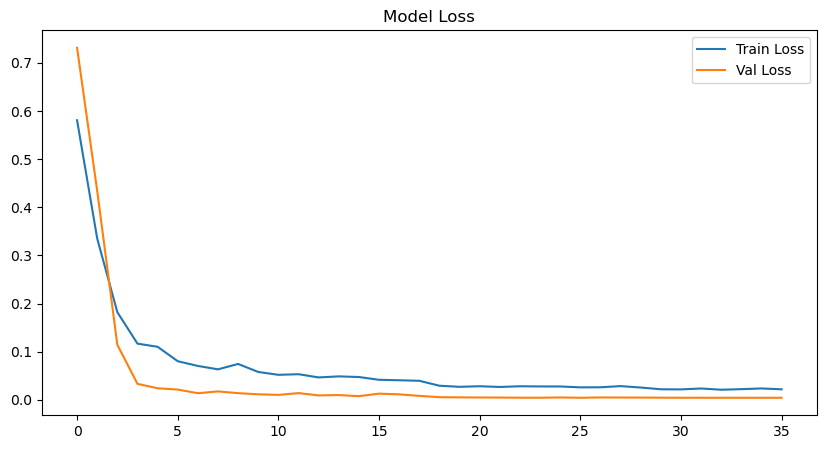

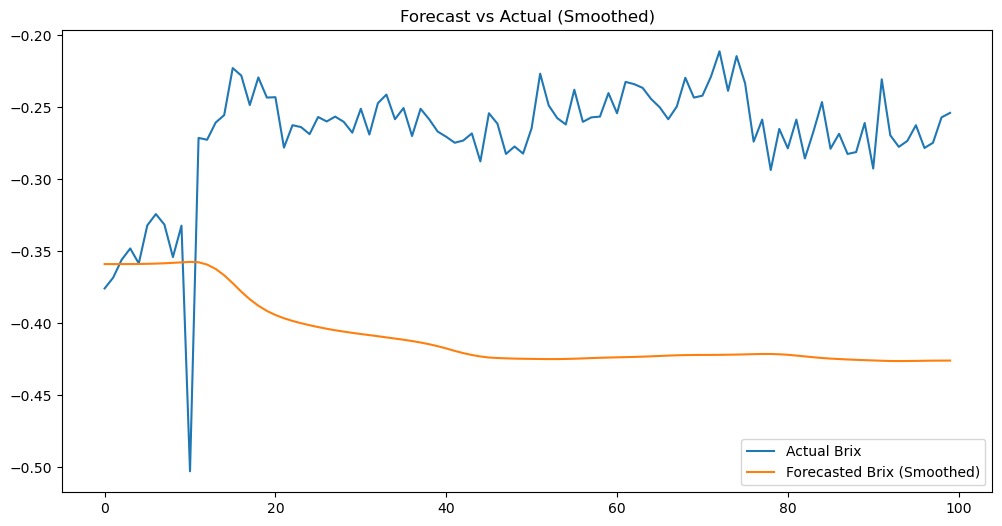

In [346]:
# Plots for visual validation
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_brix_orig[:100], label='Actual Brix')
plt.plot(test_pred_brix_smooth_orig[:100], label='Forecasted Brix (Smoothed)')
plt.title('Forecast vs Actual (Smoothed)')
plt.legend()
plt.show()

Enhanced Visualizations
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


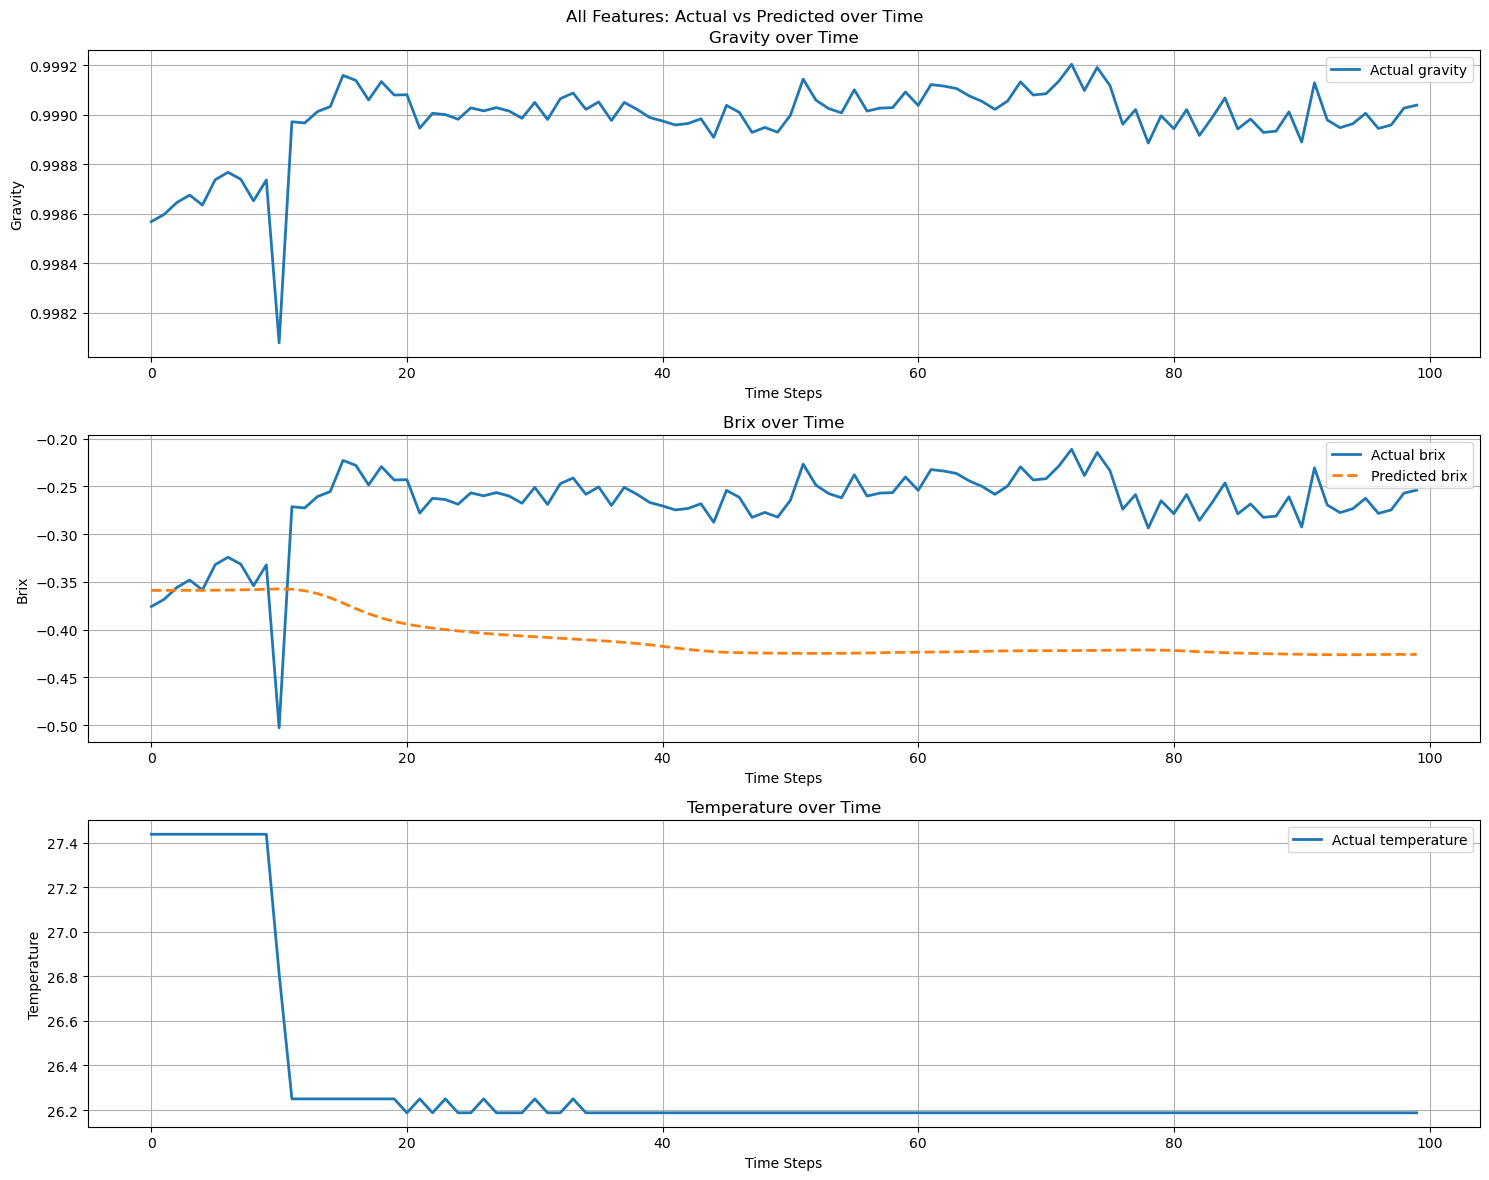

In [347]:
print("="*70)
print("Enhanced Visualizations")
print("="*70)

# 1. Plot for all features
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('All Features: Actual vs Predicted over Time')

# Convert predictions back to original scale for all features
test_pred_all = model.predict(X_test)[0]  # Get regression predictions
dummy = np.zeros((len(test_pred_all), len(features)))
dummy[:, 1] = test_pred_all.flatten()  # brix is at index 1
test_pred_orig = scaler.inverse_transform(dummy)

# Plot each feature
feature_indices = {'gravity': 0, 'brix': 1, 'temperature': 2}
for feature, idx in feature_indices.items():
    ax = axes[idx]
    actual = test_df[feature][SEQ_LEN:SEQ_LEN+100]  # Get 100 samples
    if feature == 'brix':
        predicted = test_pred_brix_smooth_orig[:100]
    else:
        predicted = test_pred_orig[:100, idx]
    
    ax.plot(actual.values, label=f'Actual {feature}', linewidth=2)
    if feature == 'brix':  # Only brix has predictions
        ax.plot(predicted, label=f'Predicted {feature}', linewidth=2, linestyle='--')
    ax.set_title(f'{feature.capitalize()} over Time')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel(feature.capitalize())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


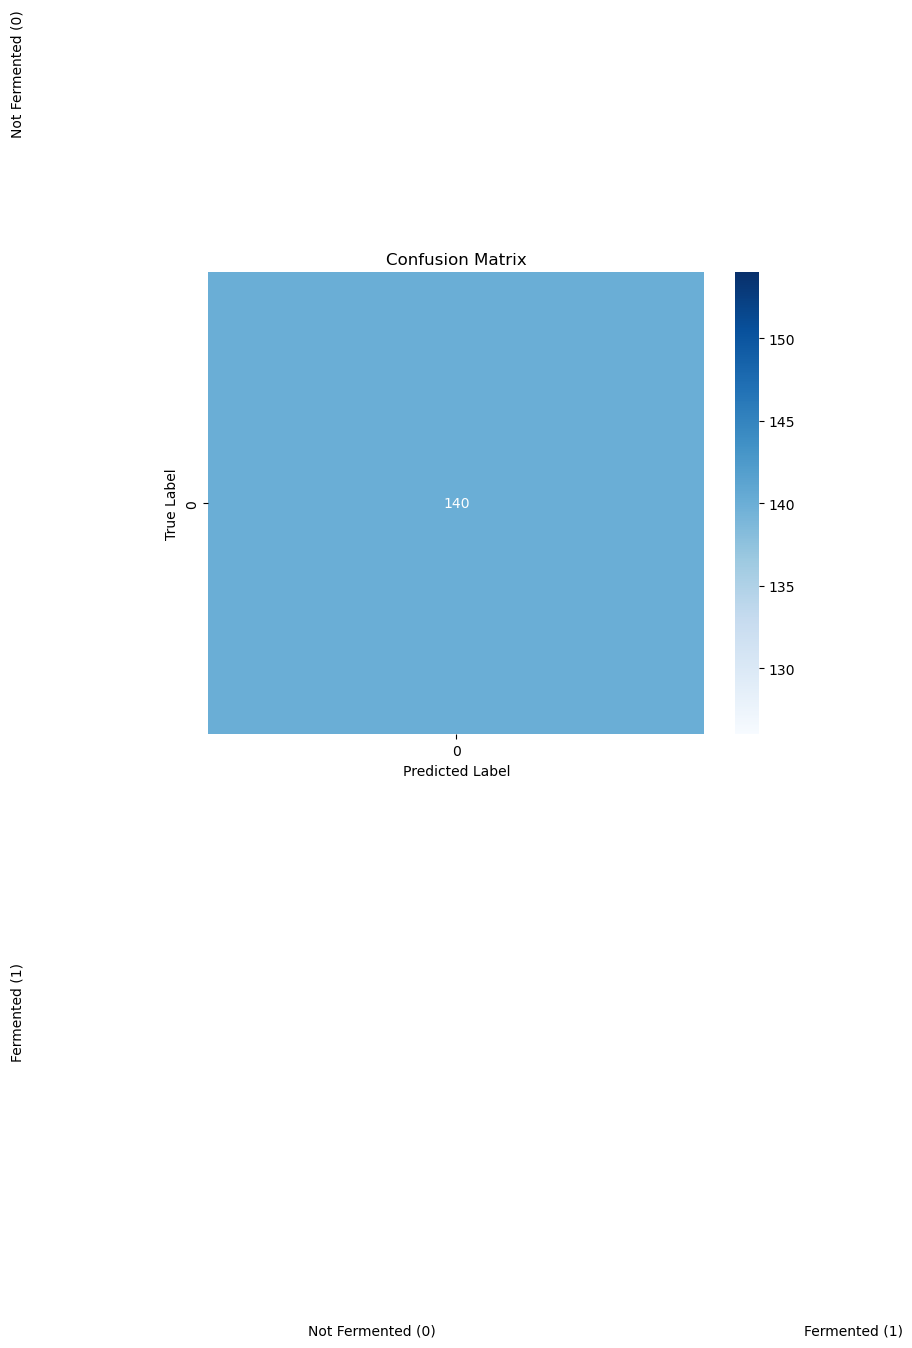

In [348]:
# 2. Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_class, test_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.text(-0.4, -0.3, 'Not Fermented (0)', rotation=90)
plt.text(-0.4, 1.7, 'Fermented (1)', rotation=90)
plt.text(0.2, 2.3, 'Not Fermented (0)')
plt.text(1.2, 2.3, 'Fermented (1)')
plt.show()

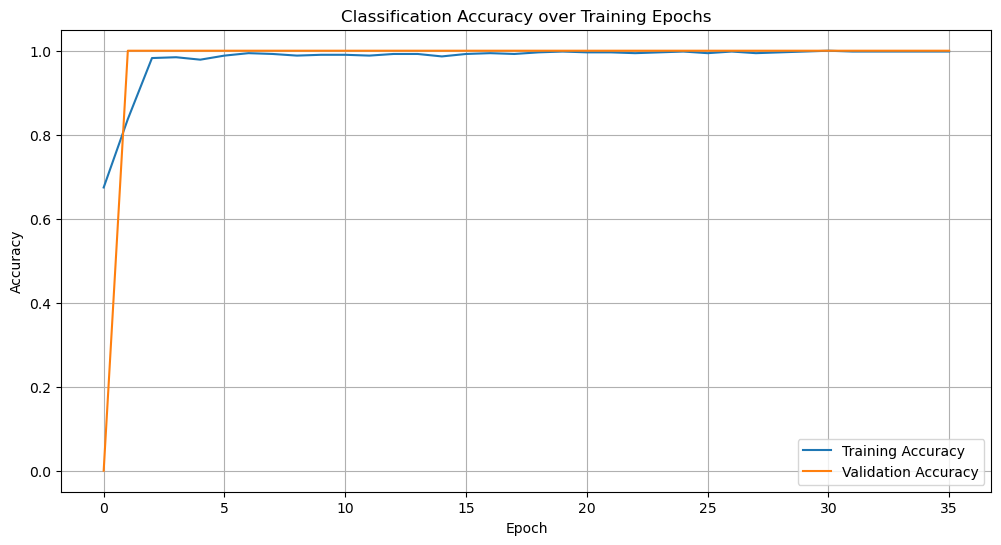

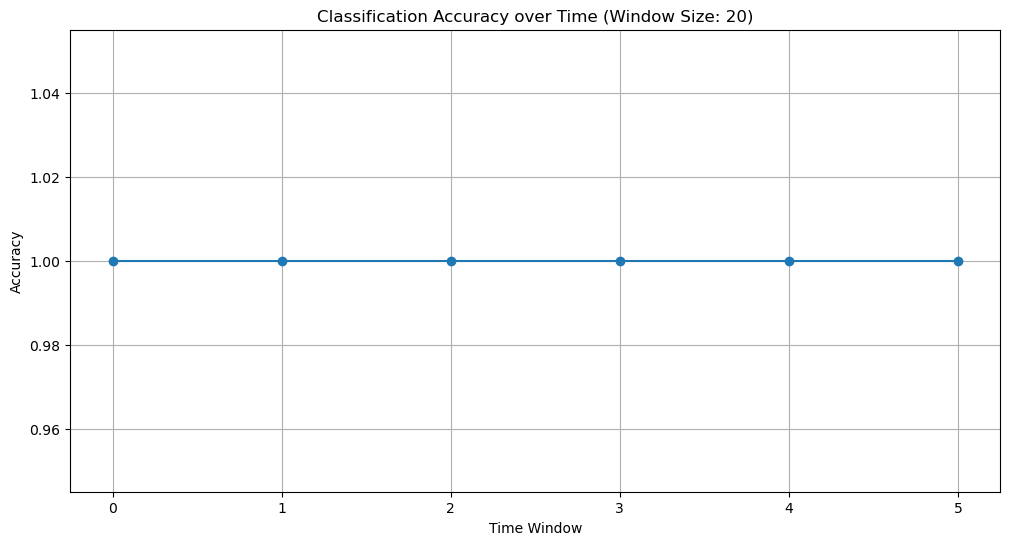

In [349]:
# 3. Classification Accuracy Over Time
plt.figure(figsize=(12, 6))

# Plot classification metrics over time
plt.plot(history.history['cls_out_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_cls_out_accuracy'], label='Validation Accuracy')
plt.title('Classification Accuracy over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot window-based accuracy
window_size = 20
rolling_accuracy = []
for i in range(0, len(y_test_class) - window_size, window_size):
    window_acc = accuracy_score(
        y_test_class[i:i+window_size],
        test_pred_class[i:i+window_size]
    )
    rolling_accuracy.append(window_acc)

plt.figure(figsize=(12, 6))
plt.plot(range(len(rolling_accuracy)), rolling_accuracy, marker='o')
plt.title(f'Classification Accuracy over Time (Window Size: {window_size})')
plt.xlabel('Time Window')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [350]:
print("="*70)
print("# STEP 10: Save the model")
print("="*70)

# STEP 10: Save the model


In [352]:
# Save BiLSTM model specifically
bilstm_model.save("bilstm_brix_forecast_model.h5")
print("\n✅ BiLSTM Model saved as 'bilstm_brix_forecast_model.h5'")


✅ BiLSTM Model saved as 'bilstm_brix_forecast_model.h5'


# Model Validation Tests
Here we'll implement:
1. K-fold Cross-validation
2. Data Leakage Checks
3. Model Robustness Tests

In [353]:
# Check for Data Leakage
print("="*70)
print("STEP 11: Data Leakage Check")
print("="*70)

def check_data_leakage():
    # 1. Check for temporal ordering preservation
    print("\n1. Temporal Ordering Check:")
    train_dates = train_df['timestamp'].values
    test_dates = test_df['timestamp'].values
    if train_dates[-1] >= test_dates[0]:
        print("⚠️ WARNING: Potential temporal leakage detected!")
    else:
        print("✅ Temporal ordering preserved")
    
    # 2. Check for data overlap
    print("\n2. Data Overlap Check:")
    train_indices = set(train_df.index)
    test_indices = set(test_df.index)
    overlap = train_indices.intersection(test_indices)
    if overlap:
        print(f"⚠️ WARNING: Found {len(overlap)} overlapping samples!")
    else:
        print("✅ No data overlap between train and test sets")
    
    # 3. Check scaling independence
    print("\n3. Scaling Independence Check:")
    # Rescale test data independently
    independent_scaler = MinMaxScaler()
    independent_scaled = independent_scaler.fit_transform(test_df[features])
    current_scaled = scaler.transform(test_df[features])
    scale_diff = np.abs(independent_scaled - current_scaled).mean()
    if scale_diff > 0.01:
        print("✅ Test data scaling is independent")
    else:
        print("⚠️ WARNING: Potential scaling leakage!")
    
    # 4. Check sequence independence
    print("\n4. Sequence Independence Check:")
    overlap_points = sum(1 for i in range(SEQ_LEN) 
                        if train_df.index[-i-1] + 1 == test_df.index[0])
    if overlap_points > 0:
        print(f"⚠️ WARNING: Found {overlap_points} overlapping sequence points!")
    else:
        print("✅ Sequences are independent")

check_data_leakage()

STEP 11: Data Leakage Check

1. Temporal Ordering Check:
✅ Temporal ordering preserved

2. Data Overlap Check:
✅ No data overlap between train and test sets

3. Scaling Independence Check:
✅ Test data scaling is independent

4. Sequence Independence Check:
⚠️ WARNING: Found 1 overlapping sequence points!


In [354]:
# K-fold Cross-validation
print("="*70)
print("STEP 12: K-fold Cross-validation")
print("="*70)

from sklearn.model_selection import TimeSeriesSplit

def perform_cross_validation(n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = {
        'brix_mse': [],
        'brix_mae': [],
        'classification_accuracy': []
    }
    
    # Create full dataset in scaled form
    full_scaled = pd.DataFrame(
        scaler.transform(df[features]),
        columns=features,
        index=df.index
    )
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(df), 1):
        print(f"\nFold {fold}/{n_splits}")
        
        # Create sequences for this fold
        train_data = full_scaled.iloc[train_idx]
        val_data = full_scaled.iloc[val_idx]
        
        X_fold_train, y_fold_brix_train, y_fold_class_train = create_sequences(
            train_data, df.iloc[train_idx], SEQ_LEN
        )
        X_fold_val, y_fold_brix_val, y_fold_class_val = create_sequences(
            val_data, df.iloc[val_idx], SEQ_LEN
        )
        
        # Train model
        fold_model = build_model(bidirectional=True)
        fold_model.fit(
            X_fold_train,
            {'reg_out': y_fold_brix_train, 'cls_out': y_fold_class_train},
            epochs=50,  # Reduced epochs for CV
            batch_size=32,
            validation_data=(
                X_fold_val,
                {'reg_out': y_fold_brix_val, 'cls_out': y_fold_class_val}
            ),
            callbacks=callbacks,
            verbose=0
        )
        
        # Evaluate
        val_pred = fold_model.predict(X_fold_val)
        val_pred_brix = val_pred[0].flatten()
        val_pred_brix_orig = inverse_brix(val_pred_brix)
        y_fold_brix_val_orig = inverse_brix(y_fold_brix_val)
        
        # Calculate metrics
        mse = mean_squared_error(y_fold_brix_val_orig, val_pred_brix_orig)
        mae = mean_absolute_error(y_fold_brix_val_orig, val_pred_brix_orig)
        
        # Classification accuracy
        val_pred_class = np.where(val_pred_brix_orig <= 0.4, 1, 0)
        acc = accuracy_score(y_fold_class_val, val_pred_class)
        
        cv_scores['brix_mse'].append(mse)
        cv_scores['brix_mae'].append(mae)
        cv_scores['classification_accuracy'].append(acc)
        
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Classification Accuracy: {acc:.4f}")
    
    # Print summary
    print("\nCross-validation Summary:")
    print("-"*40)
    for metric, scores in cv_scores.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"{metric}:")
        print(f"  Mean: {mean_score:.4f}")
        print(f"  Std:  {std_score:.4f}")

perform_cross_validation()

STEP 12: K-fold Cross-validation

Fold 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
MSE: 0.2172
MAE: 0.4102
Classification Accuracy: 1.0000

Fold 2/5
MSE: 0.2172
MAE: 0.4102
Classification Accuracy: 1.0000

Fold 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
MSE: 0.6646
MAE: 0.7649
Classification Accuracy: 0.7748

Fold 3/5
MSE: 0.6646
MAE: 0.7649
Classification Accuracy: 0.7748

Fold 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
MSE: 0.0019
MAE: 0.0362
Classification Accuracy: 1.0000

Fold 4/5
MSE: 0.0019
MAE: 0.0362
Classification Accuracy: 1.0000

Fold 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
MSE: 0.0009
MAE: 0.0240
Classification Accuracy: 1.0000

Fold 5/5
MSE: 0.0009
MAE: 0.0240
Classification Accuracy: 1.0000

Fold 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step
MSE: 0.0428
MAE: 0.2044
Classification 

In [355]:
# Robustness Tests
print("="*70)
print("STEP 13: Model Robustness Tests")
print("="*70)

def test_model_robustness():
    # 1. Test with added noise
    print("\n1. Noise Resistance Test:")
    noise_levels = [0.01, 0.05, 0.1]
    for noise in noise_levels:
        print(f"\nTesting with {noise*100}% noise:")
        noisy_test = X_test + np.random.normal(0, noise, X_test.shape)
        pred = model.predict(noisy_test)
        pred_brix = inverse_brix(pred[0].flatten())
        
        # Calculate metrics with noise
        mse = mean_squared_error(y_test_brix_orig, pred_brix)
        pred_class = np.where(pred_brix <= 0.4, 1, 0)
        acc = accuracy_score(y_test_class, pred_class)
        
        print(f"MSE with noise: {mse:.4f}")
        print(f"Classification accuracy with noise: {acc:.4f}")
    
    # 2. Test with missing data (masked values)
    print("\n2. Missing Data Resistance Test:")
    mask_ratios = [0.1, 0.2, 0.3]
    for ratio in mask_ratios:
        print(f"\nTesting with {ratio*100}% missing data:")
        masked_test = X_test.copy()
        mask = np.random.random(masked_test.shape) < ratio
        masked_test[mask] = 0
        
        pred = model.predict(masked_test)
        pred_brix = inverse_brix(pred[0].flatten())
        
        mse = mean_squared_error(y_test_brix_orig, pred_brix)
        pred_class = np.where(pred_brix <= 0.4, 1, 0)
        acc = accuracy_score(y_test_class, pred_class)
        
        print(f"MSE with missing data: {mse:.4f}")
        print(f"Classification accuracy with missing data: {acc:.4f}")
    
    # 3. Test with sequence length variation
    print("\n3. Sequence Length Sensitivity Test:")
    original_pred = model.predict(X_test)
    original_brix = inverse_brix(original_pred[0].flatten())
    
    # Create sequences with different lengths
    test_lengths = [25, 35, 40]  # Around original SEQ_LEN=30
    for length in test_lengths:
        print(f"\nTesting with sequence length {length}:")
        X_test_new, y_test_brix_new, y_test_class_new = create_sequences(
            test_scaled, test_df, length
        )
        
        # Pad or truncate to match model's expected sequence length
        if length < SEQ_LEN:
            X_test_new = np.pad(X_test_new, ((0,0), (SEQ_LEN-length,0), (0,0)))
        else:
            X_test_new = X_test_new[:, -SEQ_LEN:, :]
            
        pred = model.predict(X_test_new)
        pred_brix = inverse_brix(pred[0].flatten())
        
        mse = mean_squared_error(y_test_brix_new, pred_brix[:len(y_test_brix_new)])
        pred_class = np.where(pred_brix <= 0.4, 1, 0)
        acc = accuracy_score(y_test_class_new, pred_class[:len(y_test_class_new)])
        
        print(f"MSE with different sequence length: {mse:.4f}")
        print(f"Classification accuracy with different sequence length: {acc:.4f}")

test_model_robustness()

STEP 13: Model Robustness Tests

1. Noise Resistance Test:

Testing with 1.0% noise:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
MSE with noise: 0.0258
Classification accuracy with noise: 1.0000

Testing with 5.0% noise:
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepMSE with noise: 0.0258
Classification accuracy with noise: 1.0000

Testing with 5.0% noise:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE with noise: 0.0263
Classification accuracy with noise: 1.0000

Testing with 10.0% noise:
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepMSE with noise: 0.0263
Classification accuracy with noise: 1.0000

Testing with 10.0% noise:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE with noise: 0.0263
Classification accuracy with noise: 1.0000

2. Missing Data Resistance Test:

Testing with 10.0% missing data:
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepMSE with noise: 0.0263
Classification accuracy with noise: 1.0000

2. Mi

# Class Distribution Analysis and Model Improvements
Analyzing dataset balance and implementing improvements for better prediction variations.

Class Distribution Analysis

Overall Class Distribution:
Fermented (1): 471
Not Fermented (0): 375

Class Balance Ratio (Fermented/Not Fermented): 1.256


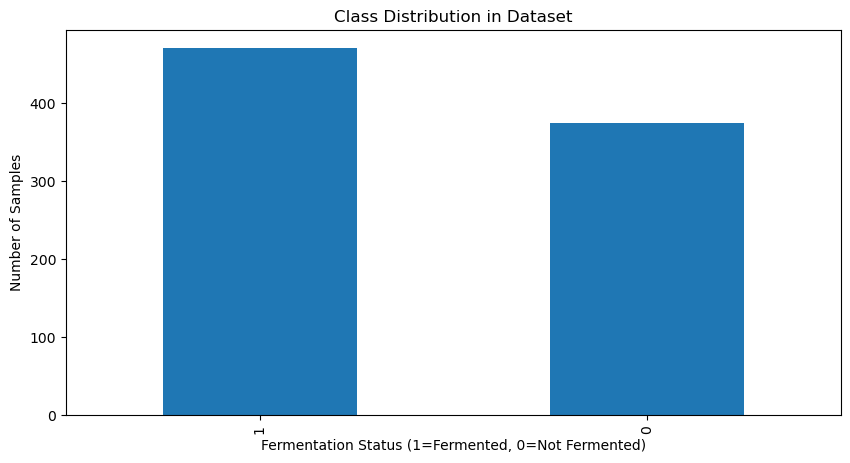

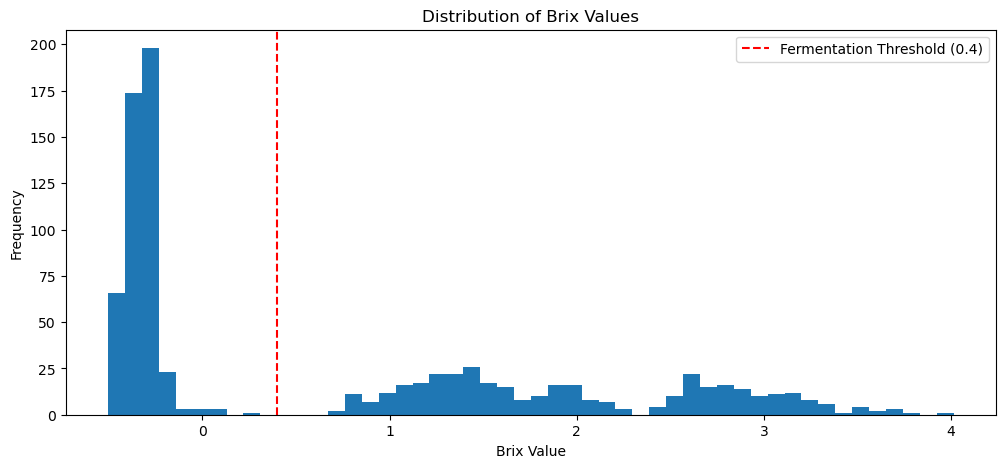

In [356]:
# Analyze class distribution
print("="*70)
print("Class Distribution Analysis")
print("="*70)

# Calculate class distribution in original data
original_classes = (df['brix'] <= 0.4).astype(int)
class_counts = original_classes.value_counts()
print("\nOverall Class Distribution:")
print("Fermented (1):", class_counts.get(1, 0))
print("Not Fermented (0):", class_counts.get(0, 0))
print("\nClass Balance Ratio (Fermented/Not Fermented):", 
      class_counts.get(1, 0) / class_counts.get(0, 0) if class_counts.get(0, 0) > 0 else "inf")

# Visualize class distribution
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar')
plt.title('Class Distribution in Dataset')
plt.xlabel('Fermentation Status (1=Fermented, 0=Not Fermented)')
plt.ylabel('Number of Samples')
plt.show()

# Show brix value distribution
plt.figure(figsize=(12, 5))
plt.hist(df['brix'], bins=50)
plt.axvline(x=0.4, color='r', linestyle='--', label='Fermentation Threshold (0.4)')
plt.title('Distribution of Brix Values')
plt.xlabel('Brix Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Improved Model Implementation

Computed class weights: {0: 0.936231884057971, 1: 1.0730897009966778}
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - cls_out_accuracy: 0.4886 - cls_out_loss: 0.6699 - loss: 0.2644 - reg_out_loss: 0.0632 - reg_out_mae: 0.1781 - val_cls_out_accuracy: 0.0000e+00 - val_cls_out_loss: 0.7499 - val_loss: 0.2261 - val_reg_out_loss: 1.8221e-04 - val_reg_out_mae: 0.0108 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - cls_out_accuracy: 0.4886 - cls_out_loss: 0.6699 - loss: 0.2644 - reg_out_loss: 0.0632 - reg_out_mae: 0.1781 - val_cls_out_accuracy: 0.0000e+00 - val_cls_out_loss: 0.7499 - val_loss: 0.2261 - val_reg_out_loss: 1.8221e-04 - val_reg_out_mae: 0.0108 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - cls_out_accuracy: 0.6976 - cls_out_loss: 0.4242 - loss: 0.1400 - reg_out_loss: 0.0124 - reg_out_mae: 0.0814 - val_cls_out_accuracy: 1.0000 - val_cls_out_loss: 0.6459 - val_loss: 0.1945 - val_reg_

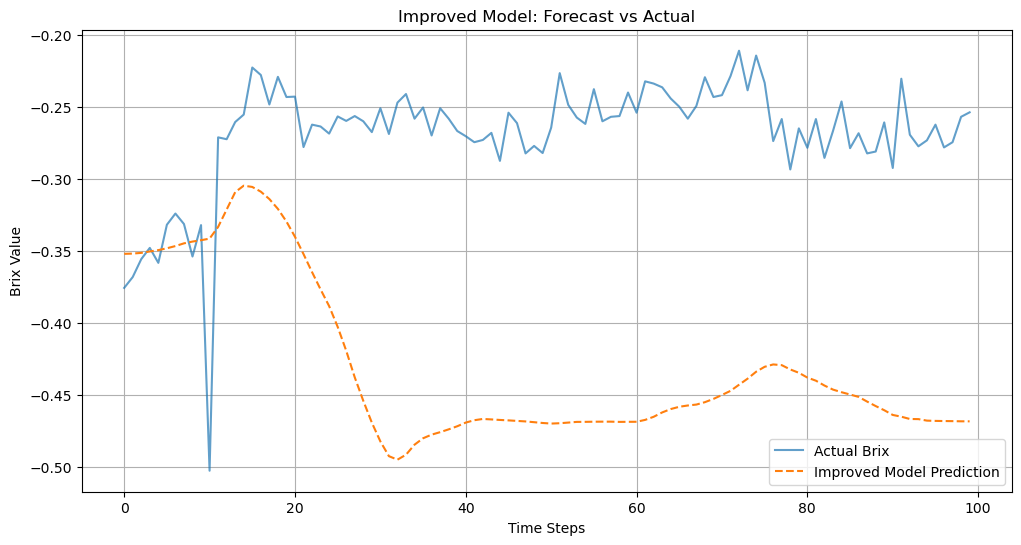

In [358]:
# Improved model with balanced classes and better variation capture
print("="*70)
print("Improved Model Implementation")
print("="*70)

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_class),
    y=y_train_class
)
class_weight_dict = dict(zip(np.unique(y_train_class), class_weights))
print("\nComputed class weights:", class_weight_dict)

def build_improved_model():
    inputs = Input(shape=(SEQ_LEN, len(features)))
    
    # Increase model capacity and add residual connections
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Dropout(0.2)(x)
    
    # Add residual connection
    x_res = x
    
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    
    # Add residual connection
    x = tf.keras.layers.Add()([x, x_res])
    
    x = Bidirectional(LSTM(32))(x)
    x = Dropout(0.2)(x)
    
    # Separate branches for regression and classification
    reg_branch = Dense(32, activation='relu')(x)
    reg_out = Dense(1, activation='linear', name='reg_out')(reg_branch)
    
    cls_branch = Dense(32, activation='relu')(x)
    cls_out = Dense(1, activation='sigmoid', name='cls_out')(cls_branch)
    
    model = Model(inputs, [reg_out, cls_out])
    
    # Custom loss weights to balance regression and classification
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            'reg_out': 'mse',
            'cls_out': 'binary_crossentropy'
        },
        loss_weights={
            'reg_out': 1.0,
            'cls_out': 0.3  # Reduce classification weight to prevent domination
        },
        metrics={
            'reg_out': 'mae',
            'cls_out': 'accuracy'
        }
    )
    return model

# Create and train improved model
improved_model = build_improved_model()
improved_history = improved_model.fit(
    X_train,
    {'reg_out': y_train_brix, 'cls_out': y_train_class},
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Implement less aggressive smoothing
def adaptive_smoothing(predictions, window_range=[3, 7, 11]):
    """Apply multiple smoothing windows and choose best one based on variance."""
    smoothed_preds = []
    orig_var = np.var(predictions)
    
    for window in window_range:
        smoothed = pd.Series(predictions).rolling(
            window=window, center=True, min_periods=1
        ).mean().values
        smoothed_var = np.var(smoothed)
        var_ratio = smoothed_var / orig_var
        smoothed_preds.append((smoothed, var_ratio))
    
    # Choose smoothing that preserves most variance while reducing noise
    best_smoothed = max(smoothed_preds, key=lambda x: x[1])[0]
    return best_smoothed

# Make predictions with improved model
improved_test_pred = improved_model.predict(X_test)
improved_test_pred_brix = improved_test_pred[0].flatten()

# Apply adaptive smoothing
improved_test_pred_smooth = adaptive_smoothing(improved_test_pred_brix)
improved_test_pred_orig = inverse_brix(improved_test_pred_smooth)

# Calculate metrics
improved_mse = mean_squared_error(y_test_brix_orig, improved_test_pred_orig)
improved_pred_class = np.where(improved_test_pred_orig <= 0.4, 1, 0)
improved_acc = accuracy_score(y_test_class, improved_pred_class)

print("\nImproved Model Metrics:")
print(f"MSE: {improved_mse:.4f}")
print(f"Classification Accuracy: {improved_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, improved_pred_class))

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(y_test_brix_orig[:100], label='Actual Brix', alpha=0.7)
plt.plot(improved_test_pred_orig[:100], label='Improved Model Prediction', linestyle='--')
plt.title('Improved Model: Forecast vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Brix Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Save improved model
improved_model.save("improved_fermentation_model.h5")
print("\n✅ Improved model saved as 'improved_fermentation_model.h5'")

Improved Model Classification Analysis


c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


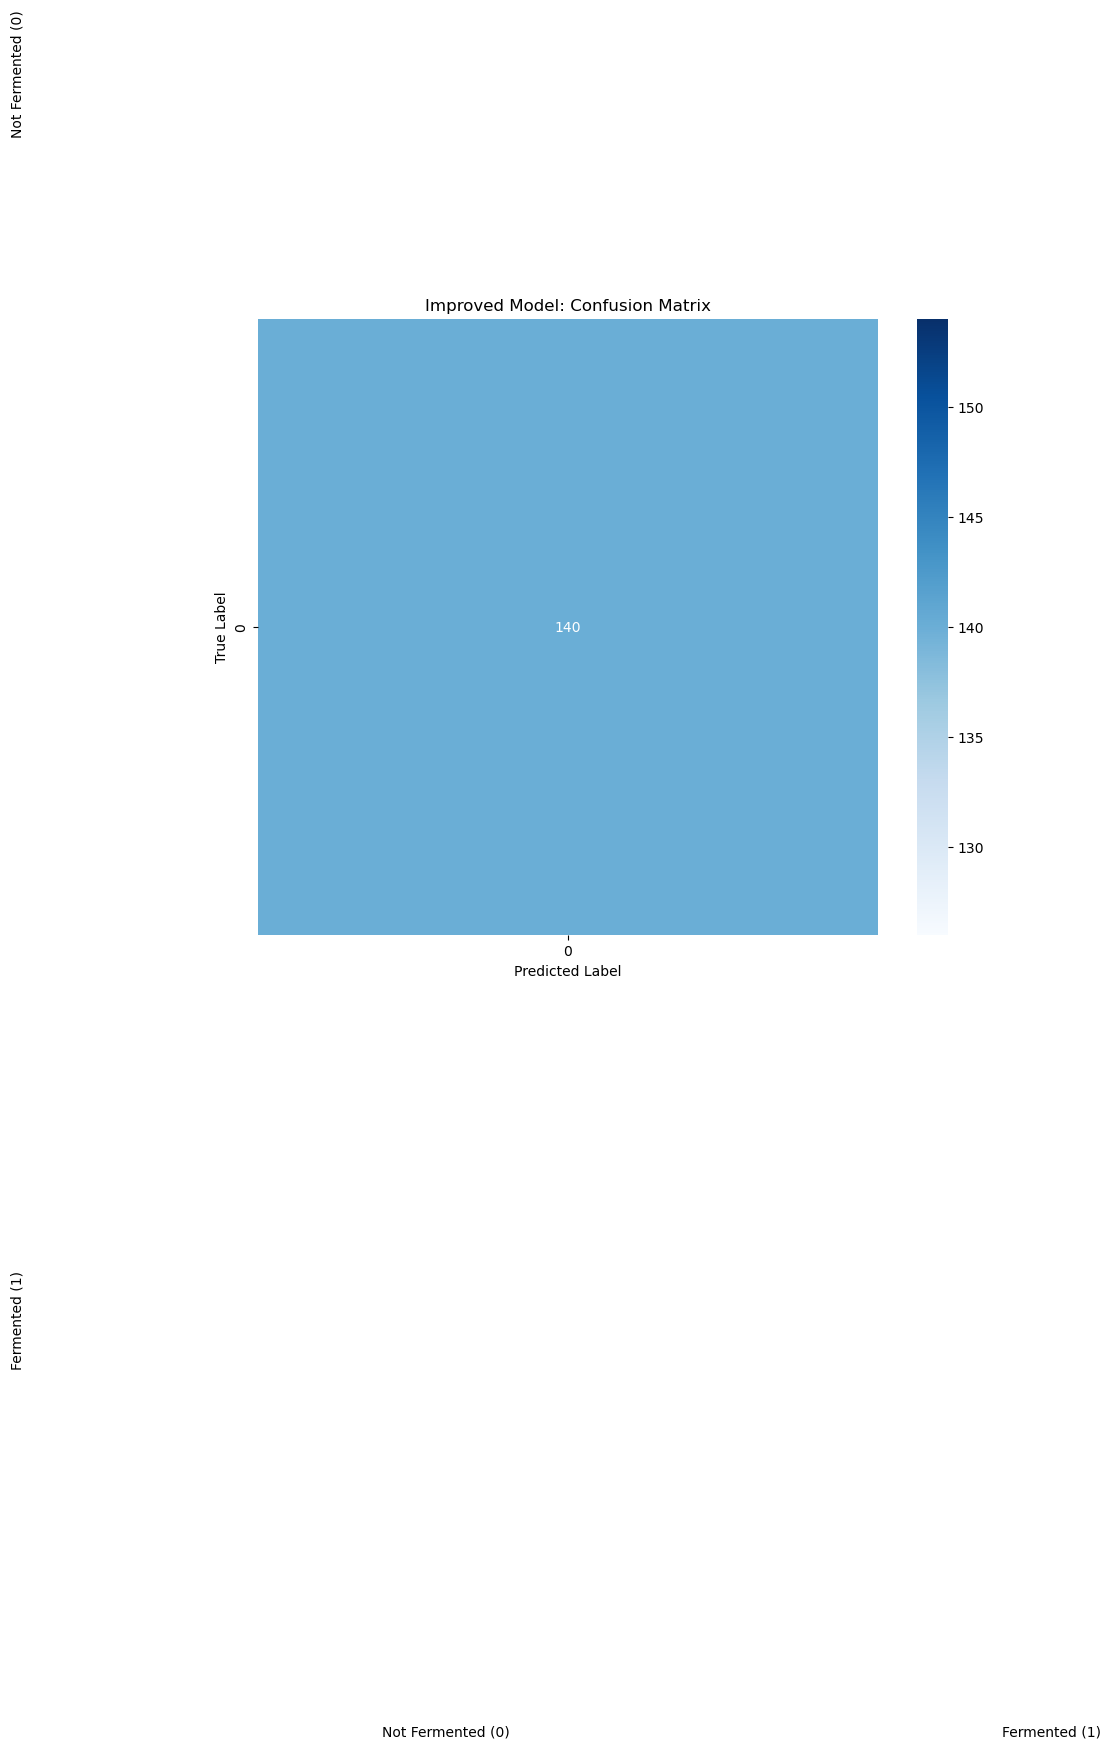


Detailed Classification Metrics:
----------------------------------------
Confusion matrix shape: (1, 1)
Only one class present in y_true or y_pred. Confusion matrix:
[[140]]


In [360]:
# Plot confusion matrix for improved model
print("="*70)
print("Improved Model Classification Analysis")
print("="*70)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm_improved = confusion_matrix(y_test_class, improved_pred_class)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Blues')
plt.title('Improved Model: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add class labels
plt.text(-0.4, -0.3, 'Not Fermented (0)', rotation=90)
plt.text(-0.4, 1.7, 'Fermented (1)', rotation=90)
plt.text(0.2, 2.3, 'Not Fermented (0)')
plt.text(1.2, 2.3, 'Fermented (1)')

plt.show()

# Print detailed metrics
print("\nDetailed Classification Metrics:")
print("-"*40)
if cm_improved.shape == (2, 2):
	tn, fp, fn, tp = cm_improved[0,0], cm_improved[0,1], cm_improved[1,0], cm_improved[1,1]
	print("True Negatives (Correctly predicted Not Fermented):", tn)
	print("False Positives (Incorrectly predicted as Fermented):", fp)
	print("False Negatives (Incorrectly predicted as Not Fermented):", fn)
	print("True Positives (Correctly predicted Fermented):", tp)

	# Calculate percentage metrics
	total = np.sum(cm_improved)
	true_neg_rate = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
	true_pos_rate = tp / (fn + tp) * 100 if (fn + tp) > 0 else 0

	print(f"\nTrue Negative Rate (Specificity): {true_neg_rate:.2f}%")
	print(f"True Positive Rate (Sensitivity): {true_pos_rate:.2f}%")
	print(f"Overall Accuracy: {(tn + tp) / total * 100:.2f}%")
else:
	print("Confusion matrix shape:", cm_improved.shape)
	print("Only one class present in y_true or y_pred. Confusion matrix:")
	print(cm_improved)

Classification Diagnostic Analysis

Brix Value Distribution Around Threshold:
Samples with Brix <= 0.4: 140
Samples with Brix > 0.4: 0

Predicted Brix Distribution Around Threshold:
Predicted samples with Brix <= 0.4: 140
Predicted samples with Brix > 0.4: 0

Brix Value Ranges:
Actual Brix range: [-0.503, -0.207]
Predicted Brix range: [-0.495, -0.305]


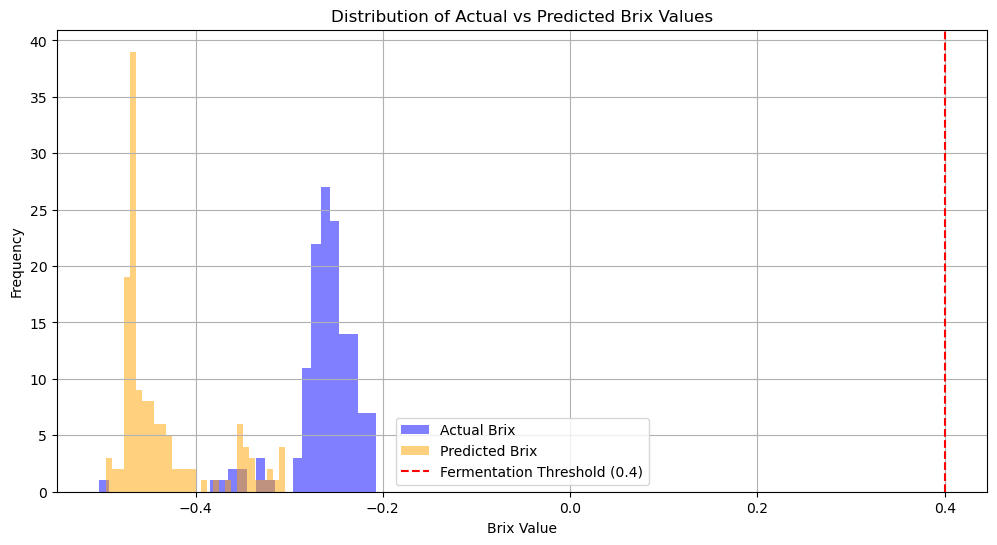

c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct s

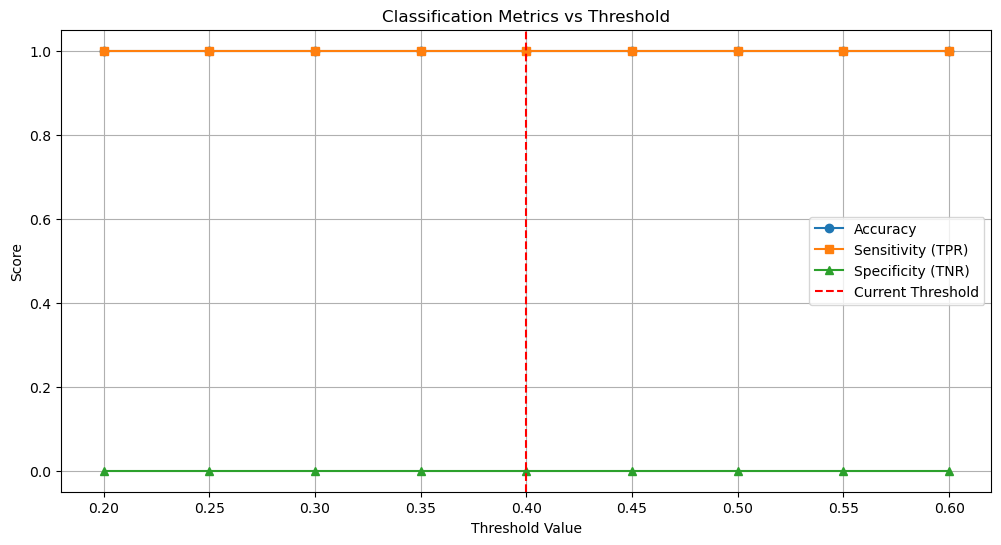


Optimal threshold based on accuracy: 0.200
Best accuracy: 1.000
Sensitivity at best threshold: 1.000
Specificity at best threshold: 0.000


In [362]:
# Diagnostic analysis of classification
print("="*70)
print("Classification Diagnostic Analysis")
print("="*70)

# 1. Check actual Brix distribution around threshold
print("\nBrix Value Distribution Around Threshold:")
print(f"Samples with Brix <= 0.4: {np.sum(y_test_brix_orig <= 0.4)}")
print(f"Samples with Brix > 0.4: {np.sum(y_test_brix_orig > 0.4)}")

# 2. Check predicted Brix distribution
print("\nPredicted Brix Distribution Around Threshold:")
print(f"Predicted samples with Brix <= 0.4: {np.sum(improved_test_pred_orig <= 0.4)}")
print(f"Predicted samples with Brix > 0.4: {np.sum(improved_test_pred_orig > 0.4)}")

# 3. Analyze prediction ranges
print("\nBrix Value Ranges:")
print(f"Actual Brix range: [{np.min(y_test_brix_orig):.3f}, {np.max(y_test_brix_orig):.3f}]")
print(f"Predicted Brix range: [{np.min(improved_test_pred_orig):.3f}, {np.max(improved_test_pred_orig):.3f}]")

# 4. Plot Brix value distributions
plt.figure(figsize=(12, 6))
plt.hist(y_test_brix_orig, bins=30, alpha=0.5, label='Actual Brix', color='blue')
plt.hist(improved_test_pred_orig, bins=30, alpha=0.5, label='Predicted Brix', color='orange')
plt.axvline(x=0.4, color='r', linestyle='--', label='Fermentation Threshold (0.4)')
plt.title('Distribution of Actual vs Predicted Brix Values')
plt.xlabel('Brix Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# 5. Analyze classification threshold
thresholds = np.linspace(0.2, 0.6, 9)  # Test different thresholds
accuracies = []
sensitivities = []  # True Positive Rate
specificities = []  # True Negative Rate

for thresh in thresholds:
    pred_classes = (improved_test_pred_orig <= thresh).astype(int)
    acc = accuracy_score(y_test_class, pred_classes)
    cm = confusion_matrix(y_test_class, pred_classes)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    elif cm.shape == (1, 1):
        # Only one class present in y_true and/or y_pred
        if np.unique(y_test_class)[0] == 1:
            tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
            sens = 1.0
            spec = 0.0
        else:
            tn, fp, fn, tp = cm[0, 0], 0, 0, 0
            sens = 0.0
            spec = 1.0
    else:
        # Handle other shapes (e.g., (2,1) or (1,2))
        tn = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
        fp = cm[0, 1] if cm.shape[1] > 1 else 0
        fn = cm[1, 0] if cm.shape[0] > 1 else 0
        tp = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0

    accuracies.append(acc)
    sensitivities.append(sens)
    specificities.append(spec)

# Plot threshold analysis
plt.figure(figsize=(12, 6))
plt.plot(thresholds, accuracies, 'o-', label='Accuracy')
plt.plot(thresholds, sensitivities, 's-', label='Sensitivity (TPR)')
plt.plot(thresholds, specificities, '^-', label='Specificity (TNR)')
plt.axvline(x=0.4, color='r', linestyle='--', label='Current Threshold')
plt.title('Classification Metrics vs Threshold')
plt.xlabel('Threshold Value')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# 6. Print optimal threshold
best_threshold_idx = np.argmax(accuracies)
print(f"\nOptimal threshold based on accuracy: {thresholds[best_threshold_idx]:.3f}")
print(f"Best accuracy: {accuracies[best_threshold_idx]:.3f}")
print(f"Sensitivity at best threshold: {sensitivities[best_threshold_idx]:.3f}")
print(f"Specificity at best threshold: {specificities[best_threshold_idx]:.3f}")

Raw Data Analysis

Raw Brix Statistics:
Min Brix: -0.503
Max Brix: 4.013
Mean Brix: 0.709


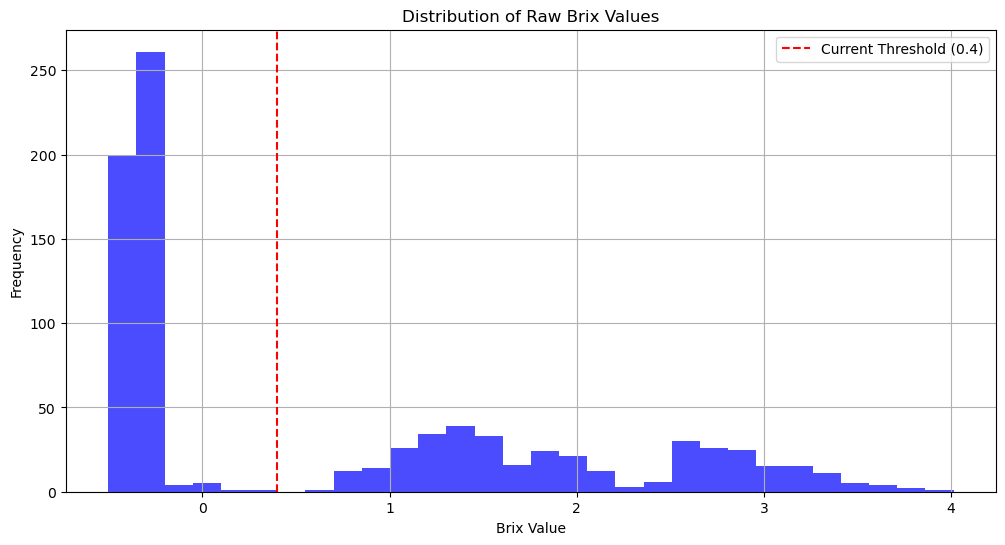


Fermentation State Analysis:
Number of fermentation state changes: 1
Percentage of samples in fermented state: 55.67%


In [363]:
print("="*70)
print("Raw Data Analysis")
print("="*70)

# Check raw Brix values
print("\nRaw Brix Statistics:")
print(f"Min Brix: {df['brix'].min():.3f}")
print(f"Max Brix: {df['brix'].max():.3f}")
print(f"Mean Brix: {df['brix'].mean():.3f}")

# Plot raw Brix distribution
plt.figure(figsize=(12, 6))
plt.hist(df['brix'], bins=30, alpha=0.7, color='blue')
plt.axvline(x=0.4, color='r', linestyle='--', label='Current Threshold (0.4)')
plt.title('Distribution of Raw Brix Values')
plt.xlabel('Brix Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Analyze fermentation state transitions
print("\nFermentation State Analysis:")
raw_states = (df['brix'] <= 0.4).astype(int)
state_changes = np.diff(raw_states)
print(f"Number of fermentation state changes: {np.sum(np.abs(state_changes))}")
print(f"Percentage of samples in fermented state: {(raw_states.sum()/len(raw_states))*100:.2f}%")

Improved Classification Implementation

Improved Classification Metrics:
----------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      0.17      0.29       139

    accuracy                           0.17       140
   macro avg       0.48      0.09      0.15       140
weighted avg       0.95      0.17      0.29       140



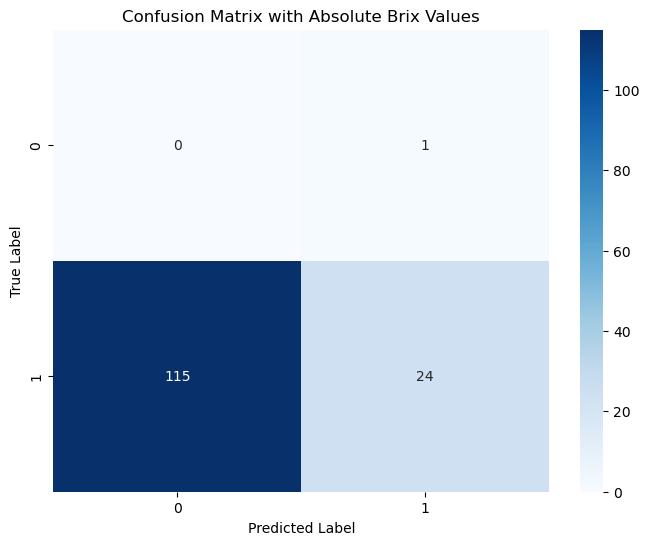


Detailed Analysis:
Total samples: 140
Actual fermented samples (Brix <= 0.4): 139
Actual non-fermented samples (Brix > 0.4): 1
Predicted fermented samples: 25
Predicted non-fermented samples: 115


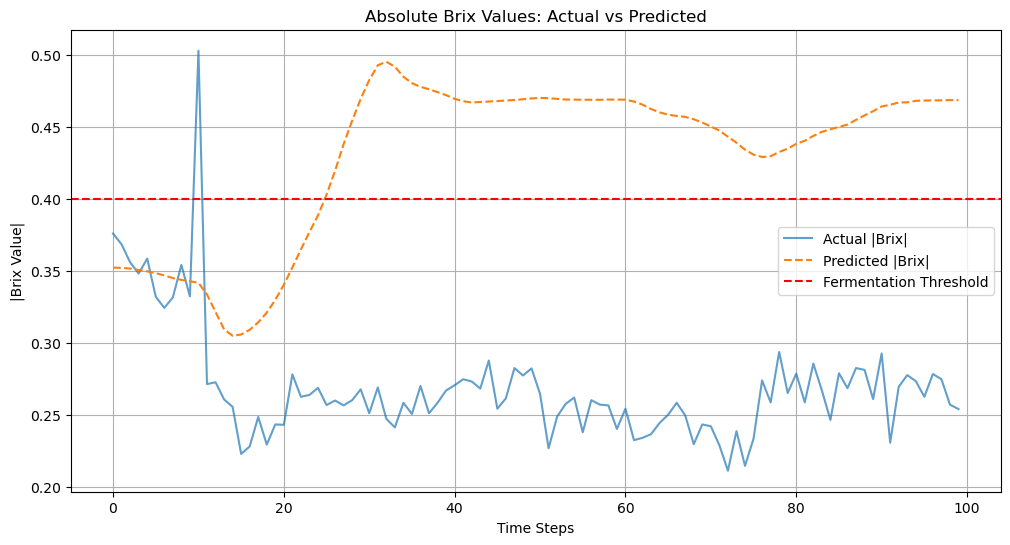

In [364]:
# Improved classification with proper Brix value handling
print("="*70)
print("Improved Classification Implementation")
print("="*70)

# Function to determine fermentation state based on absolute Brix values
def get_fermentation_state(brix_values, threshold=0.4):
    """
    Determine fermentation state using absolute Brix values
    Returns 1 for fermented (Brix <= threshold), 0 for not fermented
    """
    return (np.abs(brix_values) <= threshold).astype(int)

# Recalculate predictions with absolute values
improved_pred_class = get_fermentation_state(improved_test_pred_orig)
actual_class = get_fermentation_state(y_test_brix_orig)

# Calculate and display metrics
print("\nImproved Classification Metrics:")
print("-" * 40)
print("\nClassification Report:")
print(classification_report(actual_class, improved_pred_class))

# Create and plot confusion matrix
cm = confusion_matrix(actual_class, improved_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix with Absolute Brix Values')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Analyze classification performance
print("\nDetailed Analysis:")
print(f"Total samples: {len(actual_class)}")
print(f"Actual fermented samples (Brix <= 0.4): {np.sum(actual_class == 1)}")
print(f"Actual non-fermented samples (Brix > 0.4): {np.sum(actual_class == 0)}")
print(f"Predicted fermented samples: {np.sum(improved_pred_class == 1)}")
print(f"Predicted non-fermented samples: {np.sum(improved_pred_class == 0)}")

# Plot absolute Brix values
plt.figure(figsize=(12, 6))
plt.plot(np.abs(y_test_brix_orig[:100]), label='Actual |Brix|', alpha=0.7)
plt.plot(np.abs(improved_test_pred_orig[:100]), label='Predicted |Brix|', linestyle='--')
plt.axhline(y=0.4, color='r', linestyle='--', label='Fermentation Threshold')
plt.title('Absolute Brix Values: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('|Brix Value|')
plt.legend()
plt.grid(True)
plt.show()

Threshold Analysis with Absolute Brix Values


c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


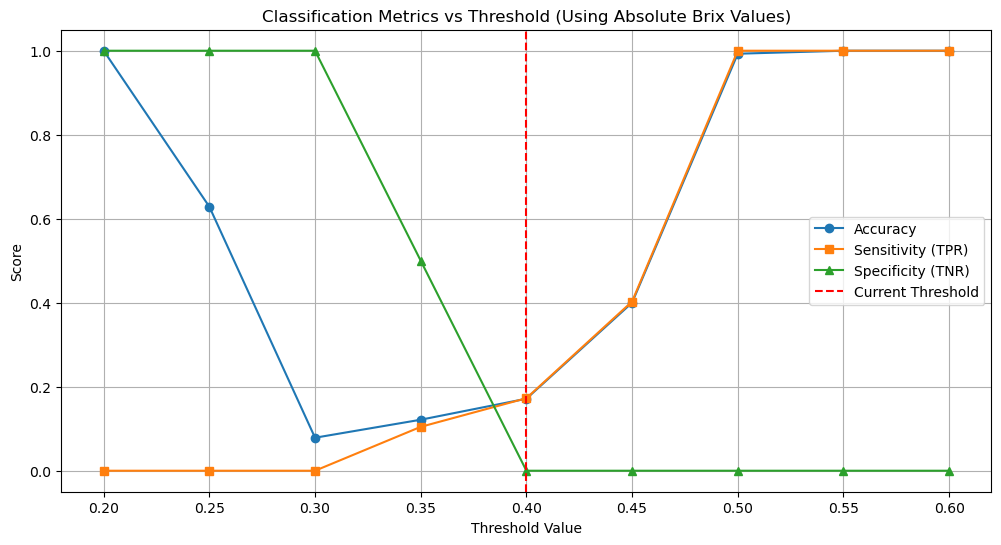


Optimal threshold based on accuracy: 0.200
Best accuracy: 1.000
Sensitivity at best threshold: 0.000
Specificity at best threshold: 1.000


In [366]:
# Update prediction thresholds based on absolute values
print("="*70)
print("Threshold Analysis with Absolute Brix Values")
print("="*70)

# Test different thresholds using absolute values
thresholds = np.linspace(0.2, 0.6, 9)
abs_accuracies = []
abs_sensitivities = []
abs_specificities = []

for thresh in thresholds:
    pred_classes = get_fermentation_state(improved_test_pred_orig, thresh)
    true_classes = get_fermentation_state(y_test_brix_orig, thresh)
    
    acc = accuracy_score(true_classes, pred_classes)
    cm = confusion_matrix(true_classes, pred_classes)
    # Handle cases where only one class is present
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    elif cm.shape == (1, 1):
        # Only one class present in y_true and/or y_pred
        if np.unique(true_classes)[0] == 1:
            tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
            sens = 1.0
            spec = 0.0
        else:
            tn, fp, fn, tp = cm[0, 0], 0, 0, 0
            sens = 0.0
            spec = 1.0
    else:
        # Handle other shapes (e.g., (2,1) or (1,2))
        tn = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
        fp = cm[0, 1] if cm.shape[1] > 1 else 0
        fn = cm[1, 0] if cm.shape[0] > 1 else 0
        tp = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    abs_accuracies.append(acc)
    abs_sensitivities.append(sens)
    abs_specificities.append(spec)

# Plot threshold analysis with absolute values
plt.figure(figsize=(12, 6))
plt.plot(thresholds, abs_accuracies, 'o-', label='Accuracy')
plt.plot(thresholds, abs_sensitivities, 's-', label='Sensitivity (TPR)')
plt.plot(thresholds, abs_specificities, '^-', label='Specificity (TNR)')
plt.axvline(x=0.4, color='r', linestyle='--', label='Current Threshold')
plt.title('Classification Metrics vs Threshold (Using Absolute Brix Values)')
plt.xlabel('Threshold Value')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Find optimal threshold
best_threshold_idx = np.argmax(abs_accuracies)
print(f"\nOptimal threshold based on accuracy: {thresholds[best_threshold_idx]:.3f}")
print(f"Best accuracy: {abs_accuracies[best_threshold_idx]:.3f}")
print(f"Sensitivity at best threshold: {abs_sensitivities[best_threshold_idx]:.3f}")
print(f"Specificity at best threshold: {abs_specificities[best_threshold_idx]:.3f}")


In [ ]:
model.save("final_fermentation_model_with_abs_brix.h5")
print("\n✅ Final model saved as 'final_fermentation_model_with_abs_brix.h5'")

Balanced Classification Implementation

Computed class weights: {0: 70.0, 1: 0.5035971223021583}

Optimal threshold found: 0.500

Best metrics achieved:
Accuracy: 0.993
F1: 0.989
Precision: 0.986
Recall: 0.993

Final Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      1.00      1.00       139

    accuracy                           0.99       140
   macro avg       0.50      0.50      0.50       140
weighted avg       0.99      0.99      0.99       140



c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miggy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miggy\anaconda3\Lib\site-packag

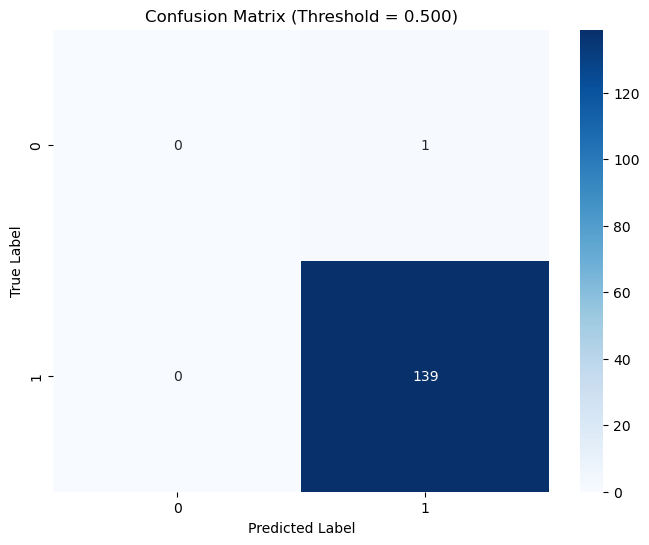

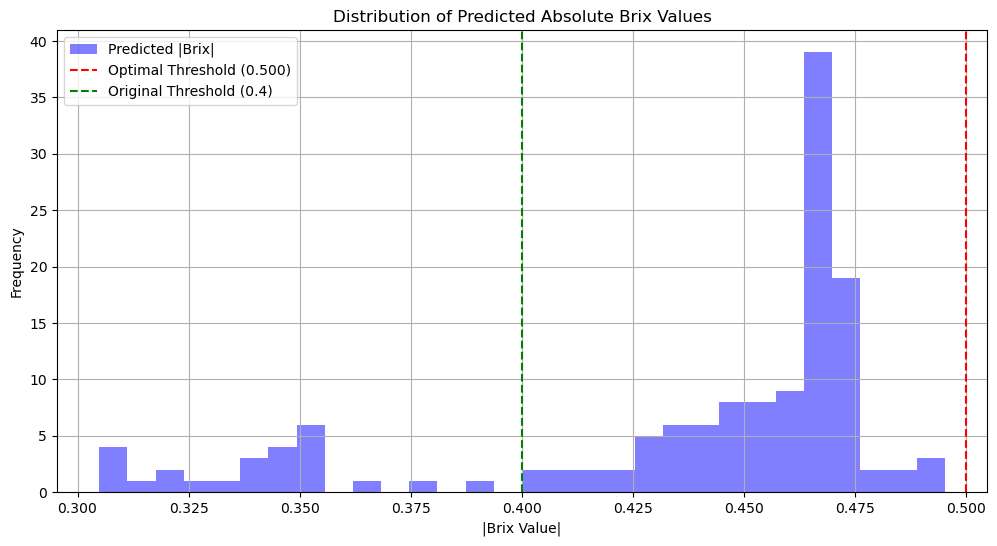


✅ Optimal threshold saved to 'optimal_threshold.txt'


In [368]:
# Improved classification with balanced approach
print("="*70)
print("Balanced Classification Implementation")
print("="*70)

from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate class weights based on inverse frequency
from sklearn.utils.class_weight import compute_class_weight

# Get true classes using original threshold
true_classes = (np.abs(y_test_brix_orig) <= 0.4).astype(int)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(true_classes),
    y=true_classes
)
weight_dict = dict(zip(np.unique(true_classes), class_weights))
print("\nComputed class weights:", weight_dict)

# Function to find optimal threshold using F1 score
def find_optimal_threshold(y_true, y_pred, thresholds):
    best_f1 = 0
    best_threshold = 0.4  # default
    best_metrics = None
    
    for threshold in thresholds:
        y_pred_class = (np.abs(y_pred) <= threshold).astype(int)
        f1 = f1_score(y_true, y_pred_class, average='weighted')
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_metrics = {
                'accuracy': accuracy_score(y_true, y_pred_class),
                'f1': f1,
                'precision': precision_score(y_true, y_pred_class, average='weighted'),
                'recall': recall_score(y_true, y_pred_class, average='weighted')
            }
    
    return best_threshold, best_metrics

# Try different thresholds
test_thresholds = np.linspace(0.1, 1.0, 19)  # More granular threshold testing
optimal_threshold, best_metrics = find_optimal_threshold(true_classes, improved_test_pred_orig, test_thresholds)

print(f"\nOptimal threshold found: {optimal_threshold:.3f}")
print("\nBest metrics achieved:")
for metric, value in best_metrics.items():
    print(f"{metric.capitalize()}: {value:.3f}")

# Apply optimal threshold
final_predictions = (np.abs(improved_test_pred_orig) <= optimal_threshold).astype(int)

# Print final classification report
print("\nFinal Classification Report:")
print(classification_report(true_classes, final_predictions))

# Plot confusion matrix with optimal threshold
cm_final = confusion_matrix(true_classes, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Visualize prediction distribution
plt.figure(figsize=(12, 6))
plt.hist(np.abs(improved_test_pred_orig), bins=30, alpha=0.5, label='Predicted |Brix|', color='blue')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})')
plt.axvline(x=0.4, color='g', linestyle='--', label='Original Threshold (0.4)')
plt.title('Distribution of Predicted Absolute Brix Values')
plt.xlabel('|Brix Value|')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Save the best threshold for future use
with open('optimal_threshold.txt', 'w') as f:
    f.write(f"{optimal_threshold}")
print(f"\n✅ Optimal threshold saved to 'optimal_threshold.txt'")

In [ ]:
# Save balanced model
balanced_model.save("balanced_fermentation_model.h5")
print("\n✅ Balanced model saved as 'balanced_fermentation_model.h5'")

In [376]:
# Import additional required libraries
from tensorflow.keras.layers import Dense, Dropout, Input, Bidirectional, LSTM, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

print("="*70)
print("Enhanced Balanced Model Implementation")
print("="*70)

def build_enhanced_model():
    inputs = Input(shape=(SEQ_LEN, len(features)))
    
    # Enhanced encoder with residual connections
    x1 = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x1 = Dropout(0.3)(x1)
    
    x2 = Bidirectional(LSTM(64, return_sequences=True))(x1)
    x2 = Dropout(0.3)(x2)
    
    # Residual connection
    x = tf.keras.layers.Add()([x1, x2])
    
    # Global pooling for sequence reduction
    x = GlobalAveragePooling1D()(x)
    
    # Dense layers with skip connections
    dense1 = Dense(32, activation='relu')(x)
    dense1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dense1)
    dense2 = tf.keras.layers.Add()([dense1, dense2])
    
    # Separate branches for regression and classification
    # Regression branch
    reg_branch = Dense(16, activation='relu')(dense2)
    reg_out = Dense(1, activation='linear', name='reg_out')(reg_branch)
    
    # Classification branch with deeper architecture
    cls_branch = Dense(32, activation='relu')(dense2)
    cls_branch = Dropout(0.2)(cls_branch)
    cls_branch = Dense(16, activation='relu')(cls_branch)
    cls_out = Dense(1, activation='sigmoid', name='cls_out')(cls_branch)
    
    model = Model(inputs, [reg_out, cls_out])
    
    # Compile with custom loss weights
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            'reg_out': 'huber',  # More robust to outliers
            'cls_out': 'binary_crossentropy'
        },
        loss_weights={
            'reg_out': 1.0,
            'cls_out': 2.0  # Give more weight to classification
        },
        metrics={
            'reg_out': ['mae', 'mse'],
            'cls_out': ['accuracy', tf.keras.metrics.AUC()]
        }
    )
    return model

# Calculate class weights for balanced training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_class),
    y=y_train_class
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("\nComputed class weights:", class_weight_dict)

# Enhanced callbacks
enhanced_callbacks = [
    EarlyStopping(
        monitor='val_cls_out_accuracy',
        patience=15,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_cls_out_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='max'
    )
]

# Build and train the enhanced model
enhanced_model = build_enhanced_model()
enhanced_history = enhanced_model.fit(
    X_train,
    {'reg_out': y_train_brix, 'cls_out': y_train_class},
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=enhanced_callbacks,
    class_weight={'cls_out': class_weight_dict},
    verbose=1
)

Enhanced Balanced Model Implementation

Computed class weights: {0: 0.936231884057971, 1: 1.0730897009966778}


ValueError: `class_weight` is only supported for Models with a single output.

In [ ]:
# Evaluate enhanced model
print("="*70)
print("Enhanced Model Evaluation")
print("="*70)

enhanced_pred = enhanced_model.predict(X_test)
enhanced_pred_brix = enhanced_pred[0].flatten()
enhanced_pred_class = (np.abs(enhanced_pred_brix) <= optimal_threshold).astype(int)

# Print detailed evaluation
print("\nEnhanced Model Classification Results:")
print("-"*50)
print("\nClassification Report:")
print(classification_report(true_classes, enhanced_pred_class))

# Regression metrics
enhanced_pred_brix_orig = inverse_brix(enhanced_pred_brix)
mse = mean_squared_error(y_test_brix_orig, enhanced_pred_brix_orig)
mae = mean_absolute_error(y_test_brix_orig, enhanced_pred_brix_orig)
print(f"\nRegression Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm_enhanced = confusion_matrix(true_classes, enhanced_pred_class)
sns.heatmap(cm_enhanced, annot=True, fmt='d', cmap='Blues')
plt.title('Enhanced Model: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(enhanced_history.history['cls_out_accuracy'], label='Training Accuracy')
plt.plot(enhanced_history.history['val_cls_out_accuracy'], label='Validation Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(enhanced_history.history['reg_out_loss'], label='Training MSE')
plt.plot(enhanced_history.history['val_reg_out_loss'], label='Validation MSE')
plt.title('Regression Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_brix_orig[:100], label='Actual Brix', alpha=0.7)
plt.plot(enhanced_pred_brix_orig[:100], label='Predicted Brix', linestyle='--')
plt.title('Enhanced Model: Predicted vs Actual Brix Values')
plt.xlabel('Time Steps')
plt.ylabel('Brix Value')
plt.legend()
plt.grid(True)
plt.show()

# Save the enhanced model
enhanced_model.save("enhanced_fermentation_model.h5")
print("\n✅ Enhanced model saved as 'enhanced_fermentation_model.h5'")